In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import gym
import collections
import random

In [7]:
def create_new_batch(env, act=-1):
    if act==-1:
        img_1 = composed(env.render(mode='rgb_array')) 
        env.step(0)
        img_2 = composed(env.render(mode='rgb_array') )
        env.step(1)
        img_3 = composed(env.render(mode='rgb_array') )
        env.step(0)
        img_4 = composed(env.render(mode='rgb_array') )
    else:
        img_1 = composed(env.render(mode='rgb_array') )
        env.step(act)
        img_2 = composed(env.render(mode='rgb_array') )
        env.step(act)
        img_3 = composed(env.render(mode='rgb_array') )
        env.step(act)
        img_4 = composed(env.render(mode='rgb_array') ) 
    return torch.stack([img_1,img_2,img_3,img_4])

def bound_reward(reward):
    if reward==0:
        return 0
    elif reward>0:
        return 1
    elif reward<0:
        return -1
def anneal_eps(epsilon, eps_min=.05):
    if epsilon-.05<eps_min:
        return eps_min
    else:
        return epsilon-.05

In [8]:
mem = collections.namedtuple('Mem', ['state', 'action','reward', 'future_state'])
class experience_replay:
    def __init__(self, N):
        self.i=0
        self.replay=[]
        self.mem_len=N
    
    def add_mem(self, state,action,reward,future_state):
        if len(self.replay)<self.mem_len:
            self.replay.append(mem(state,action,reward,future_state))
            self.i=(self.i+1)%self.mem_len
            return
        else:
            self.replay[self.i]=mem(state,action,reward,future_state)
            self.i=(self.i+1)%self.mem_len
    
    def sample_batch(self, batch_size):
        return random.sample(self.replay, batch_size)
    
class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(-1)
        return x
composed = torchvision.transforms.Compose([ torchvision.transforms.ToPILImage(),
                                            torchvision.transforms.Grayscale(1),
                                            torchvision.transforms.Resize((110,84)),
                                            torchvision.transforms.CenterCrop((84,84)),
                                            torchvision.transforms.ToTensor()])
model= torch.nn.Sequential( 
    torch.nn.Conv2d(1, 16, (8,8), stride=4), 
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, (4,4), stride=2), 
    torch.nn.ReLU(),
    Flatten(),
    torch.nn.Linear(10368, 2)
)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [9]:
D=1e6
M=30
T=50
epsilon=.8
gamma=.9
batch_size=32
env=gym.make('CartPole-v0')
er=experience_replay(D)
reward_ls=[]
env.reset()

array([-0.03652412, -0.00427668, -0.04193285, -0.03522533])

In [10]:
for eps in range(M):
    env.reset()
    batch=create_new_batch(env, act=-1)
    for t in range(T):  
        if random.random()<epsilon:
            act=env.action_space.sample()  
        else:
            Q=model(batch).data.numpy()
            act=np.argmax(Q[0])
            
        _, reward, done, _=env.step(act)
        reward=bound_reward(reward)
        reward_ls.append(reward)
        new_batch=create_new_batch(env, act=act)
        if done:
            er.add_mem(batch, act, reward, False)
        else:
            er.add_mem(batch, act, reward, new_batch)
        batch=new_batch
             
        if len(er.replay)>batch_size:
            optimizer.zero_grad()
            rnd_mini_batch=er.sample_batch(32)
            for memory in rnd_mini_batch:
                if hasattr(memory.future_state, "shape"):
                    y=memory.reward+gamma*model(memory.future_state)
                else:
                    y=memory.reward
                loss=torch.sum((y-model(memory.state))**2)
                loss.backward()
                
            optimizer.step() 
        if done:
            break
    epsilon=anneal_eps(epsilon)

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undef

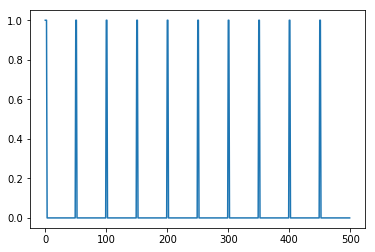

In [18]:
plt.plot(reward_ls)

In [13]:
torch.__file__

'/usr/local/lib/python3.7/site-packages/torch/__init__.py'